In [84]:
import numpy as np
import pickle
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Masking, Bidirectional, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

In [106]:
X = np.asarray(pd.read_csv("data/diabetes/X_enc.csv", header=None))
X_val = np.asarray(pd.read_csv("data/diabetes/X_val_enc.csv", header=None))
X_test = np.asarray(pd.read_csv("data/diabetes/X_test_enc.csv", header=None))
Y = np.asarray(pd.read_csv("data/diabetes/Y.csv", header=None))
Y_val = np.asarray(pd.read_csv("data/diabetes/Y_val.csv", header=None))
Y_test = np.asarray(pd.read_csv("data/diabetes/Y_test.csv", header=None))

In [107]:
print(Y.shape, Y_val.shape)

(6000, 1) (2000, 1)


In [108]:
Y

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]])

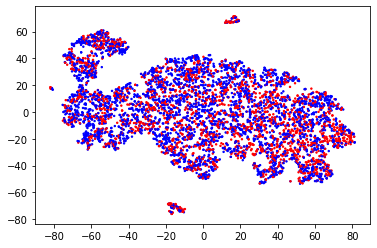

In [109]:
pca = TSNE(n_components=2).fit_transform(X)
colors = ['blue', 'red']
fig = plt.scatter(x=pca[:,0], s=2, y=pca[:,1], c=Y.astype(int).reshape(-1), cmap=matplotlib.colors.ListedColormap(colors))   

In [4]:
X_discharge_disposition = pickle.load(open("data/diabetes/X_discharge_disposition_enc.csv", "rb"))
X_val_discharge_disposition = pickle.load(open("data/diabetes/X_val_discharge_disposition_enc.csv", "rb"))
X_test_discharge_disposition = pickle.load(open("data/diabetes/X_test_discharge_disposition_enc.csv", "rb"))

In [5]:
print(X_discharge_disposition.shape)

(6000, 5, 44)


In [6]:
X_medical_speciality = pickle.load(open("data/diabetes/X_medical_speciality_enc.csv", "rb"))
X_val_medical_speciality = pickle.load(open("data/diabetes/X_val_medical_speciality_enc.csv", "rb"))
X_test_medical_speciality = pickle.load(open("data/diabetes/X_test_medical_speciality_enc.csv", "rb"))

In [7]:
print(X_medical_speciality.shape)

(6000, 3, 51)


In [8]:
X_diagnoses = pickle.load(open("data/diabetes/X_diagnoses_enc.csv", "rb")).reshape(6000, 10, -1)
X_val_diagnoses = pickle.load(open("data/diabetes/X_val_diagnoses_enc.csv", "rb")).reshape(2000, 10, -1)
X_test_diagnoses = pickle.load(open("data/diabetes/X_test_diagnoses_enc.csv", "rb")).reshape(2000, 10, -1)

In [9]:
print(X_diagnoses.shape)

(6000, 10, 3174)


In [10]:
def model():
    x = Input(shape=(65,))
    
    x_d = Input(shape=(10, 3174))
    x_dis = Input(shape=(5, 44))
    x_m = Input(shape=(3, 51))
    
    rnn_d = LSTM(30)(x_d)
    rnn_dis = LSTM(20)(x_dis)
    rnn_m = LSTM(20)(x_m)
    
    #conc = Concatenate()([x, rnn_d, rnn_dis, rnn_m])

    dense = Dense(400, activation='relu', name="dense")(x)
    dense = Dropout(.1)(dense)
    dense = BatchNormalization()(dense)
    dense = Dense(300, activation='relu', name="dense2")(dense)
    dense = Dropout(.1)(dense)
    dense = BatchNormalization()(dense)
    dense = Dense(200, activation='relu', name="dense3")(dense)
    dense = Dropout(.1)(dense)
    dense = BatchNormalization()(dense)
    dense = Dense(100, activation='relu', name="dense4")(dense)
    dense = Dropout(.1)(dense)
    dense = BatchNormalization()(dense)
    y = Dense(1, activation='sigmoid', name="y")(dense)

    model = models.Model([x], y, name="model")
    model.compile(optimizer='Adam', loss="binary_crossentropy", metrics=['acc'])

    return model

In [11]:
m = model()

In [12]:
m.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
dense (Dense)                (None, 400)               26400     
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
dense2 (Dense)               (None, 300)               120300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200  

In [13]:
Y.shape

(6000, 1)

In [110]:
cbs = []
cbs.append(EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1))
cbs.append(ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2))        
m.fit([X], Y, shuffle=True, epochs=100, \
      validation_data=([X_val], Y_val), \
      callbacks=cbs)

Train on 6000 samples, validate on 2000 samples
Epoch 1/100
6000/6000 [==============================] - 5s 857us/sample - loss: 0.7517 - acc: 0.5672 - val_loss: 0.6694 - val_acc: 0.6110
Epoch 2/100
6000/6000 [==============================] - 3s 561us/sample - loss: 0.6891 - acc: 0.5905 - val_loss: 0.6658 - val_acc: 0.6105
Epoch 3/100
6000/6000 [==============================] - 4s 588us/sample - loss: 0.6688 - acc: 0.6137 - val_loss: 0.6550 - val_acc: 0.6095
Epoch 4/100
6000/6000 [==============================] - 4s 610us/sample - loss: 0.6599 - acc: 0.6173 - val_loss: 0.6429 - val_acc: 0.6240
Epoch 5/100
6000/6000 [==============================] - 4s 592us/sample - loss: 0.6502 - acc: 0.6298 - val_loss: 0.6659 - val_acc: 0.6055
Epoch 6/100
6000/6000 [==============================] - 4s 612us/sample - loss: 0.6525 - acc: 0.6227 - val_loss: 0.6413 - val_acc: 0.6360
Epoch 7/100
6000/6000 [==============================] - 4s 598us/sample - loss: 0.6435 - acc: 0.6407 - val_loss: 0.64

In [111]:
f1_score(Y_val, m.predict(X_val).round().astype(int))

0.4216388225934765

In [113]:
print(m.predict(X_val).round().astype(int).reshape(-1)[:30])
print(Y_val.astype(int).reshape(-1)[:30])

[0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1]
[0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1]


In [98]:
import lightgbm as lgbm
params = {
    'objective' :'binary',
    'metric' : 'binary_logloss',
    'class_weight' : 'balanced'
}
d_train = lgbm.Dataset(X, Y)
d_valid = lgbm.Dataset(X_val, Y_val)
lmod = lgbm.LGBMClassifier(objective='binary', metric='binary_logloss', class_weight='balanced')
lmod.fit(X, Y.reshape(-1))
#bst = lgbm.train(params, d_train, 5000, valid_sets=[d_valid], verbose_eval=50, early_stopping_rounds=100)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, metric='binary_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [99]:
lmod.predict(X_val).sum()

816.0

In [100]:
f1_score(Y_val, lmod.predict(X_val).round().astype(int))

0.5394655065257924

In [101]:
from sklearn.svm import SVC

In [102]:
clf = SVC(gamma='auto', class_weight='balanced')
clf.fit(X, Y.reshape(-1).astype(int))

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [103]:
p = clf.predict(X_val)

In [104]:
f1_score(Y_val, clf.predict(X_val).round().astype(int))

0.5044386422976501

In [105]:
print(Y_test[:30].reshape(-1).astype(int))
print(clf.predict(X_val)[:30])

[0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0]
[0 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1]


In [96]:
p.sum()

829

In [46]:
Y

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]])